**Общая информация**

**Срок сдачи:** 21 октября 2020, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets, preprocessing
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier, KDTree
from sklearn.metrics import accuracy_score, make_scorer, pairwise_distances
from sklearn.preprocessing import MaxAbsScaler

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
        self.dim = None
        self.n_fit = None
        self.scaler = MaxAbsScaler()
    
    def fit(self, X, y):
        self.dim, self.n_fit = X.shape
        self.y_fit = np.asarray(y)
        self.X_fit = self.scaler.fit_transform(X, y)
        # self.X_fit = X
    
    def predict_brute(self, X):
        X = self.scaler.transform(X)
        dist_mat = pairwise_distances(X, self.X_fit, self.metric) # sp.spatial.distance.cdist(X, self.X_fit, self.metric)
        fit_neighbors = self.y_fit[np.argsort(dist_mat, axis=1)[:, :self.n_neighbors]]
        y_pred = sp.stats.mode(fit_neighbors, axis=1).mode.reshape(1, -1)
        return y_pred.reshape(-1,)
    
    def predict_kd_tree(self, X):
        X = self.scaler.transform(X)
        tree = KDTree(self.X_fit, leaf_size=10, metric=self.metric)
        idx = tree.query(X, k=self.n_neighbors, return_distance=False)
        fit_neighbors = self.y_fit[idx]
        y_pred = sp.stats.mode(fit_neighbors, axis=1).mode.reshape(1, -1)
        return y_pred.reshape(-1, )
    
    
    def predict(self, X):
        if self.algorithm == 'brute':
            return self.predict_brute(X)
        elif self.algorithm == 'kd_tree':
            return self.predict_kd_tree(X)
        else:
            return None
    
    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
my_score = accuracy_score(y_test, my_clf_pred)
sklearn_score = accuracy_score(y_test, sklearn_pred)
assert (sklearn_score - my_score)  < 0.005, "Score must be simillar"
print("My ", accuracy_score(y_test, my_clf_pred))
print("SKL ", accuracy_score(y_test, sklearn_pred))

# данный код генерирует ошибку, если мой скор лучше библиотеки на 0.5+ (бывает 0.6666 иногда)
# sklearn_pred = clf.predict(X_test)
# my_clf_pred = my_clf.predict(X_test)
# assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

My  1.0
SKL  1.0


**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [10]:
%time clf.fit(X_train, y_train)

CPU times: user 780 µs, sys: 0 ns, total: 780 µs
Wall time: 619 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [11]:
%time my_clf.fit(X_train, y_train)

CPU times: user 867 µs, sys: 0 ns, total: 867 µs
Wall time: 720 µs


In [12]:
%time clf.predict(X_test)

CPU times: user 3.44 ms, sys: 0 ns, total: 3.44 ms
Wall time: 2.82 ms


array([0, 0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1])

In [13]:
%time my_clf.predict(X_test)

CPU times: user 1.75 ms, sys: 948 µs, total: 2.7 ms
Wall time: 2.07 ms


array([0, 0, 2, 2, 0, 1, 0, 1, 2, 1, 2, 0, 2, 1, 1])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [14]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [15]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [16]:
%time clf.fit(X_train, y_train)

CPU times: user 1.62 ms, sys: 0 ns, total: 1.62 ms
Wall time: 2.03 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [17]:
%time my_clf.fit(X_train, y_train)

CPU times: user 421 µs, sys: 0 ns, total: 421 µs
Wall time: 427 µs


In [18]:
%time clf.predict(X_test)

CPU times: user 4.08 ms, sys: 248 µs, total: 4.33 ms
Wall time: 3.56 ms


array([2, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 2])

In [19]:
%time my_clf.predict(X_test)

CPU times: user 2.18 ms, sys: 1 ms, total: 3.18 ms
Wall time: 2.52 ms


array([2, 2, 0, 1, 1, 1, 1, 1, 0, 0, 2, 1, 0, 0, 2])

In [20]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
my_score = accuracy_score(y_test, my_clf_pred)
sklearn_score = accuracy_score(y_test, sklearn_pred)
assert (sklearn_score - my_score)  < 0.005, "Score must be simillar"
print("My ", accuracy_score(y_test, my_clf_pred))
print("SKL ", accuracy_score(y_test, sklearn_pred))

# данный код генерирует ошибку, если мой скор лучше библиотеки на 0.5+ (бывает 0.6666 иногда)
# sklearn_pred = clf.predict(X_test)
# my_clf_pred = my_clf.predict(X_test)
# assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

My  0.9333333333333333
SKL  0.9333333333333333


**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [21]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [22]:
data = newsgroups['data']
target = newsgroups['target']
len(data)

11314

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [23]:
vectorizer = CountVectorizer(min_df=0.01)
vectorizer_full = CountVectorizer()
X = vectorizer.fit_transform(data)
Y = vectorizer_full.fit_transform(data)
print("CUT: ", type(X), X.shape)
print("FULL: ", type(Y), Y.shape)

CUT:  <class 'scipy.sparse.csr.csr_matrix'> (11314, 1380)
FULL:  <class 'scipy.sparse.csr.csr_matrix'> (11314, 101631)


*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено её 
использовать sklearn.cross_validation


In [24]:
kf = KFold(n_splits=3, shuffle=True, random_state=424242).split(X, target)
split_idx = []
for train_idx, test_idx in kf:
  split_idx.append((train_idx, test_idx))


In [25]:
res0 = []
for k_neighbors in range(1, 16):
    my_clf = MyKNeighborsClassifier(n_neighbors=k_neighbors, algorithm='brute')
    summ = 0
    cnt = 0
    for train_idx, test_idx in split_idx:
        my_clf.fit(X[train_idx], target[train_idx])
        summ += accuracy_score(my_clf.predict(X[test_idx]), target[test_idx])
        cnt += 1
        if cnt == 3:
            break
    res0.append(summ / cnt)
    print("k =", k_neighbors, res0[-1])
    

k = 1 0.16598951140492
k = 2 0.1438922826328329
k = 3 0.14256714771499
k = 4 0.1445113444597142
k = 5 0.15061049896237955
k = 6 0.1541454575245832
k = 7 0.15776923178591543
k = 8 0.15821099029363925
k = 9 0.15900672271570007
k = 10 0.16015567915701293
k = 11 0.15847628911417613
k = 12 0.15662027534460257
k = 13 0.15361516452838772
k = 14 0.15326163586425737
k = 15 0.1540570167729971


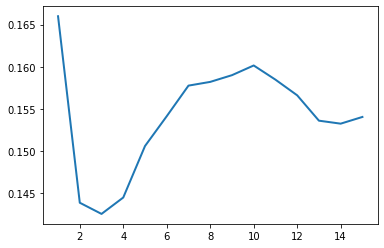

In [26]:
ax1 = plt.plot(range(1, 16), res0, linewidth=2)
plt.show()

#Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [27]:
#CountVectorizer + euclidean metric

res = []
for k in range(1, 21):
    res.append(cross_val_score(MyKNeighborsClassifier(n_neighbors=k), Y, target, cv=KFold(n_splits=3, shuffle=True, random_state=424242), scoring=make_scorer(accuracy_score)))
    print(k, res[-1])

1 [0.24867444 0.22487404 0.23495094]
2 [0.18875928 0.17608062 0.18377088]
3 [0.17470838 0.16945107 0.1705118 ]
4 [0.1659597  0.16732962 0.1633519 ]
5 [0.16171792 0.1633519  0.16414744]
6 [0.15111347 0.15963935 0.16229117]
7 [0.14607635 0.15354018 0.15990453]
8 [0.13653234 0.15088836 0.15619199]
9 [0.13414634 0.15062318 0.14770618]
10 [0.12778367 0.14611509 0.14372845]
11 [0.12566278 0.144524   0.14001591]
12 [0.12539767 0.13895518 0.13683373]
13 [0.12433722 0.13683373 0.13206046]
14 [0.12407211 0.13418191 0.12967383]
15 [0.12513256 0.13285601 0.12463538]
16 [0.12062566 0.12834792 0.12543092]
17 [0.11903499 0.1286131  0.12596128]
18 [0.1169141  0.12622647 0.12198356]
19 [0.11717922 0.12224874 0.11880138]
20 [0.1169141  0.12224874 0.11747547]


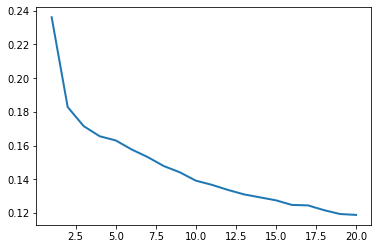

In [28]:
ax1 = plt.plot(range(1, 21), [sum(i) / 3 for i in res], linewidth=2)
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [29]:
#CountVectorizer + cosine metric

res2 = []
for k in range(1, 21):
    res2.append(cross_val_score(MyKNeighborsClassifier(n_neighbors=k, metric='cosine'), Y, target, cv=KFold(n_splits=3, shuffle=True, random_state=424242), scoring=make_scorer(accuracy_score)))
    print(k, res2[-1])

1 [0.4300106  0.40068947 0.42376028]
2 [0.37009544 0.35958632 0.35852559]
3 [0.38600212 0.3757624  0.37655794]
4 [0.40243902 0.39273402 0.39777247]
5 [0.42099682 0.40944047 0.41607001]
6 [0.43504772 0.42376028 0.43198091]
7 [0.44565217 0.42800318 0.44417926]
8 [0.44379639 0.43330682 0.4465659 ]
9 [0.45201485 0.44391408 0.44736144]
10 [0.46235419 0.44789181 0.45452135]
11 [0.46659597 0.45584726 0.4638027 ]
12 [0.47269353 0.46327234 0.47281888]
13 [0.47375398 0.4638027  0.47706179]
14 [0.4790562  0.46804561 0.47997879]
15 [0.48462354 0.47494033 0.4884646 ]
16 [0.48435843 0.47732697 0.49032087]
17 [0.48780488 0.47626624 0.49005569]
18 [0.49231177 0.48024397 0.48952532]
19 [0.49257688 0.48289578 0.49748077]
20 [0.49787911 0.4826306  0.4956245 ]


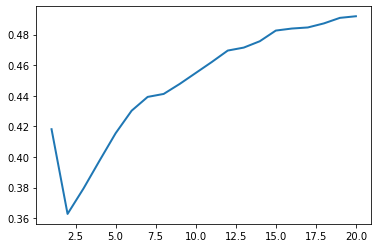

In [30]:
ax2 = plt.plot(range(1, 21), [sum(i) / 3 for i in res2], linewidth=2)
plt.show()

In [31]:
#TfidfVectorizer + euclidean metric

tf = TfidfTransformer()
Z = tf.fit_transform(Y) # Y - full vocabulary

res3 = []
for k in range(1, 21):
    res3.append(cross_val_score(MyKNeighborsClassifier(n_neighbors=k), Z, target, cv=KFold(n_splits=3, shuffle=True, random_state=424242), scoring=make_scorer(accuracy_score)))
    print(k, res3[-1])

1 [0.12513256 0.12543092 0.12330947]
2 [0.09862142 0.09652612 0.09493503]
3 [0.08377519 0.08750994 0.08777513]
4 [0.07688229 0.08141077 0.07690268]
5 [0.07396607 0.07822859 0.07319014]
6 [0.07449629 0.07478123 0.07027314]
7 [0.07608696 0.07504641 0.06629541]
8 [0.07635207 0.07425086 0.06735614]
9 [0.07794274 0.06974277 0.06709096]
10 [0.07502651 0.06709096 0.06735614]
11 [0.0747614  0.06894723 0.06815168]
12 [0.07290562 0.06762132 0.06841687]
13 [0.07051962 0.06762132 0.06576505]
14 [0.06601273 0.0649695  0.06682578]
15 [0.06468717 0.06205251 0.06470432]
16 [0.06124072 0.06576505 0.06576505]
17 [0.06177094 0.0678865  0.06443914]
18 [0.05965005 0.0678865  0.0636436 ]
19 [0.06044539 0.06974277 0.06576505]
20 [0.05885472 0.06443914 0.0649695 ]


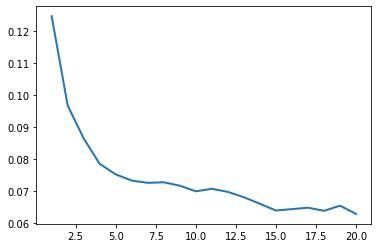

In [32]:
ax3 = plt.plot(range(1, 21), [sum(i) / 3 for i in res3], linewidth=2)
plt.show()

In [33]:
#TfidfVectorizer + cosine metric

res4 = []
for k in range(1, 21):
    res4.append(cross_val_score(MyKNeighborsClassifier(n_neighbors=k, metric='cosine'), Z, target, cv=KFold(n_splits=3, shuffle=True, random_state=424242), scoring=make_scorer(accuracy_score)))
    print(k, res4[-1])

1 [0.48462354 0.48024397 0.48316097]
2 [0.47242842 0.46035534 0.4537258 ]
3 [0.49973489 0.49217714 0.48713869]
4 [0.52757158 0.52983294 0.51896049]
5 [0.54427359 0.55078229 0.54256165]
6 [0.56707317 0.55873774 0.55953328]
7 [0.57290562 0.57305754 0.57040573]
8 [0.5771474  0.58313445 0.56457173]
9 [0.58510074 0.58711217 0.56801909]
10 [0.58828208 0.58658181 0.56722355]
11 [0.58483563 0.59002917 0.57014055]
12 [0.58377519 0.58843808 0.57411827]
13 [0.58748674 0.58631663 0.58101299]
14 [0.58616119 0.59002917 0.58021745]
15 [0.58722163 0.59082471 0.57650491]
16 [0.58775186 0.5924158  0.5794219 ]
17 [0.58960764 0.59692389 0.58074781]
18 [0.59411453 0.59718907 0.58366481]
19 [0.59888653 0.59692389 0.58499072]
20 [0.59597031 0.59692389 0.5823389 ]


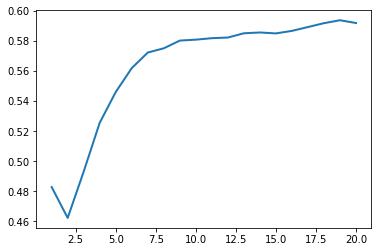

BEST k = 19 , best CV-score = 0.593600381284156


0.5800773357427462

In [37]:
dots = [sum(i) / 3 for i in res4]
ax4 = plt.plot(range(1, 21), dots, linewidth=2)
plt.show()
k_best = np.argmax(dots[1:]) + 2
print("BEST k =", k_best, ", best CV-score =", dots[k_best - 1])

k_almost_best = 9
dots[8]

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [46]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [47]:
data_t = newsgroups['data']
target_t = newsgroups['target']
len(data_t)

7532

In [48]:
vectorizer_t = CountVectorizer()
vectorizer_t.fit(data, data_t)
X = vectorizer_t.transform(data)
W = vectorizer_t.transform(data_t)
tf_t = TfidfTransformer()
tf_t.fit(X, W)
X = tf_t.transform(X)
W = tf_t.transform(W)
print("TRAIN: ", type(X), X.shape)
print("TEST: ", type(W), W.shape)

TRAIN:  <class 'scipy.sparse.csr.csr_matrix'> (11314, 101631)
TEST:  <class 'scipy.sparse.csr.csr_matrix'> (7532, 101631)


In [49]:
my_clf_2 = MyKNeighborsClassifier(k_almost_best, metric='cosine')
my_clf_2.fit(X, target)
y_pred = my_clf_2.predict(W)
accuracy_score(target_t, y_pred)

0.5191184280403611

In [50]:
my_clf_2 = MyKNeighborsClassifier(k_best, metric='cosine')
my_clf_2.fit(X, target)
y_pred = my_clf_2.predict(W)
accuracy_score(target_t, y_pred)

0.5523101433882103

Вероятно, точность ухудшилась, т.к. в тестовой выборке появились новые слова, кторых не было в тренировочной. 